# Introduction/Abstract

Data set from King County Washington.

# Packages Needed/Setting Global Variables

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.stats.api as sms




pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def Decade(List):
    decade_list=[]
    oldest = List.min()
    i=0
    for x in List:
        i += 1
        while len(decade_list) < i:
            if (x >= oldest) & (x < (oldest+10)):
                decade_list.append('{}-{}'.format(oldest,(oldest+10)))
            oldest += 10
        oldest = List.min()
    return decade_list

In [3]:
def zoningLat(List):
    lowest = List.min()
    highest = List.max()
    distance = highest - lowest
    distance = math.ceil(distance*69)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/69) <= entry) &(entry < (lowest + zone/69)):
                zones.append(zone)
    return zones

def zoningLong(List):
    lowest = List.min()
    highest = List.max()
    distance = highest-lowest
    distance = math.ceil(distance*54.6)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/54.6) <= entry) & (entry < (lowest + zone/54.6)):
                zones.append(zone)
    return zones

In [4]:
def FromCenter(Lat,Long):
    Latdiff=[]
    Longdiff=[]
    for LatEntry in Lat:
        Latdiff.append(47.6050-LatEntry)
    for LongEntry in Long:
        Longdiff.append(-122.3344-LongEntry)
    Latdiff = [(x*69)**2 for x in Latdiff]
    Longdiff = [(x*54.6)**2 for x in Longdiff]
    distance = [np.sqrt(a + b) for a, b in zip(Latdiff, Longdiff)]
    return distance

In [5]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            #included.remove(worst_feature)
            del included[worst_feature]
            
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [57]:
def ModelCheck(X_train, y_train, X_test, y_test):
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
 
    residuals = model.resid
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,10))
    
    ax1.set_title('Homoscedasticity Check')
    ax1.set_ylabel('Residuals')
    ax1.set_xlabel('Price')
    ax1.axhline(y=0, color='r', linestyle='-')
    ax2.set_title('QQ plot')

    ax1.scatter(x=y_train,y=residuals);
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax2);

    fig.show()
    
    names = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
    bp_test = sms.het_breuschpagan(residuals, model.model.exog)
    print(dict(zip(names,bp_test)))
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    print('Train Mean Squarred Error:', train_mse)
    print('Test Mean Squarred Error:', test_mse)
    print('Train Mean Error:',np.sqrt(train_mse))
    print('Test Mean Error:',np.sqrt(test_mse))
    print('Difference in Mean Error:', np.sqrt(test_mse)-np.sqrt(train_mse))
    
    return model.summary()

In [86]:
def LoggedModelCheck(X_train, y_train, X_test, y_test):
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
 
    residuals = model.resid
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,10))
    
    ax1.set_title('Homoscedasticity Check')
    ax1.set_ylabel('Residuals')
    ax1.set_xlabel('Price')
    ax1.axhline(y=0, color='r', linestyle='-')
    ax2.set_title('QQ plot')

    ax1.scatter(x=y_train,y=residuals);
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax2);

    fig.show()
    
    names = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
    bp_test = sms.het_breuschpagan(residuals, model.model.exog)
    print(dict(zip(names,bp_test)))
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    y_hat_train = np.exp(y_hat_train)
    y_hat_test = np.exp(y_hat_test)
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    print('Train Mean Squarred Error:', train_mse)
    print('Test Mean Squarred Error:', test_mse)
    print('Train Mean Error:',np.sqrt(train_mse))
    print('Test Mean Error:',np.sqrt(test_mse))
    print('Difference in Mean Error:', np.sqrt(test_mse)-np.sqrt(train_mse))
    
    return model.summary()

# EDA

## Questions about the Data

## Import and Clean the Data

In [7]:
# Import the dataset
df = pd.read_csv('kc_house_data.csv')

#Dropping id column
df = df.drop(['id'],axis=1)

#Dropping outliers using transformed std deviation of 2.5 (99%)
#Logging price to create a normal distribution and then using that std to drop outliers
df['log_price'] = df['price'].map(lambda x: np.log(x))
maximum_log_price= df.log_price.mean() + (2.5*df.log_price.std())
minimum_log_price = df.log_price.mean() - (2.5*df.log_price.std())
df = df[(df['log_price'] >= minimum_log_price ) & 
            (df['log_price'] <= maximum_log_price)]
df = df.drop(['log_price'],axis=1)

# Creating a new column for the year sold, dropping origianl date
df['year_sold'] = df.date.apply(lambda x: x[-4:]).astype(int)
df = df.drop(['date'], axis=1)

# Changing bedroom number for outlier, I think it was a typo of hitting 3 twice
# based off of the sqft
df.at[15856, 'bedrooms'] = 3

# Replacing NaN values in 'waterfront' with 0
df['waterfront'] = df['waterfront'].fillna(0)

# Replacing NaN values in view with the median/mode value which is 0 (63 entries)
# 0 means house was not viewed
df['view'] = df['view'].fillna(0)

# Replacing ? in sqft_basement and converting to float
df['sqft_basement'] = df['sqft_basement'].replace('?',0).astype(float)

# yr_renovated and renovated columns
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['Renovated'] = df['yr_renovated'] > 0
df['Renovated'] = df['Renovated'].astype(int)
df['yr_renovated'] = df['yr_renovated'].replace(0,df['yr_built'])

#Adding column for age when sold
df['Age_When_Sold'] = df['year_sold'] - df['yr_built']

#Adding column for years since renovation when sold and dropping yr_renovated
df['Age_Since_Renovation'] = df['year_sold'] - df['yr_renovated']

#Adding interaction variable Renovated*Age since renovation
df['Renovated*Age'] = df['Renovated'] * df['Age_Since_Renovation']

#Adding zones for Lat and Long
df['Lat_Zones'] = zoningLat(df['lat'])
df['Long_Zones'] = zoningLong(df['long'])
df['Lat_Zones'] = df['Lat_Zones'].astype(str)
df['Long_Zones'] = df['Long_Zones'].astype(str)
df['DistanceFromCenterOfSeattle'] = FromCenter(df['lat'],df['long'])
#df['Zones'] = df['Lat_Zones'] + 'x' + df['Long_Zones']
df = df.drop(['lat','long','Long_Zones','Lat_Zones'],axis=1)

#Grouping year built by decade
df['yr_built'] = Decade(df.yr_built)

#Dropping 'year_sold',only seems to have two years, not valuable category
df = df.drop(['year_sold'], axis=1)

## Linearity and preprocessing

In [8]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold,Age_Since_Renovation,Renovated*Age,DistanceFromCenterOfSeattle
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1950-1960,1955.0,98178,1340,5650,0,59,59.0,0.0,7.729734
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1950-1960,1991.0,98125,1690,7639,1,63,23.0,23.0,8.048045
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1930-1940,1933.0,98028,2720,8062,0,82,82.0,0.0,10.711811
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1960-1970,1965.0,98136,1360,5000,0,49,49.0,0.0,6.632568
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1980-1990,1987.0,98074,1800,7503,0,28,28.0,0.0,15.822203


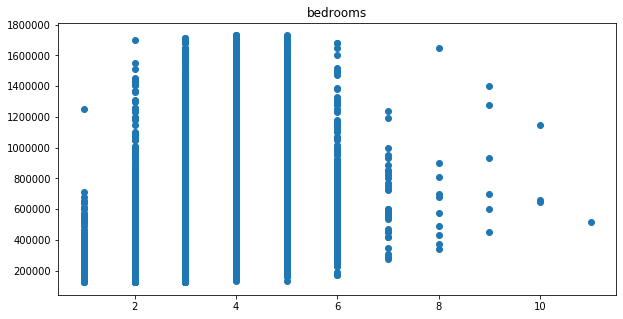

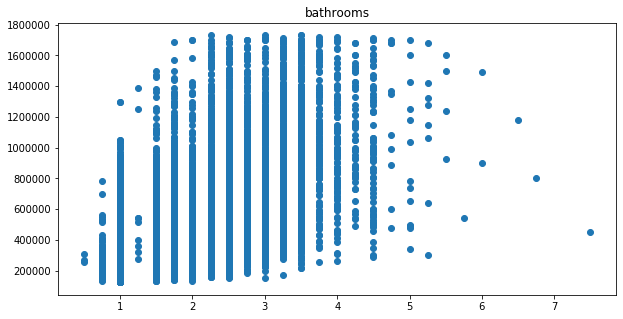

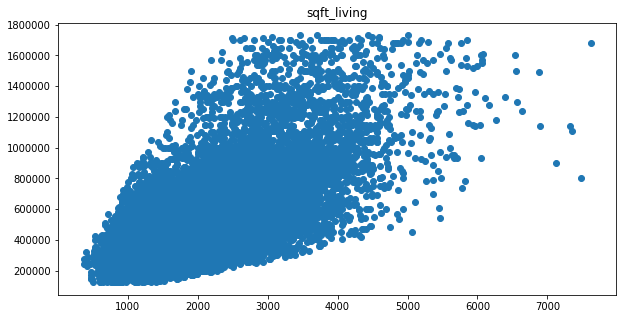

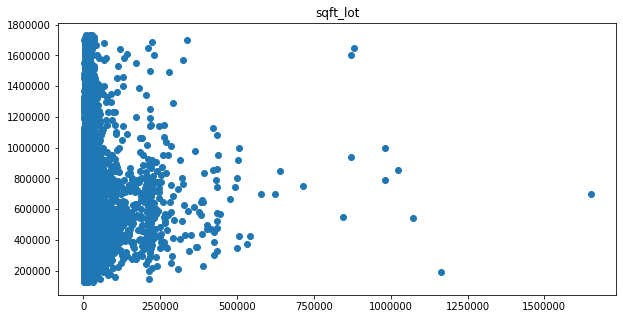

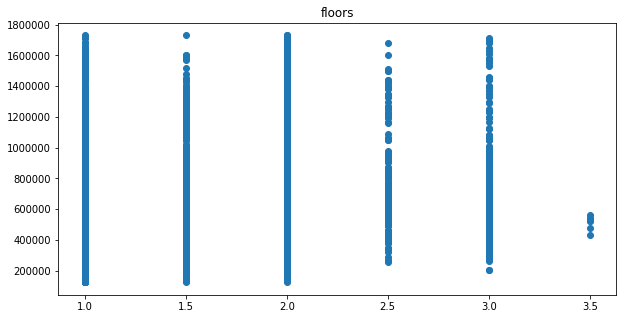

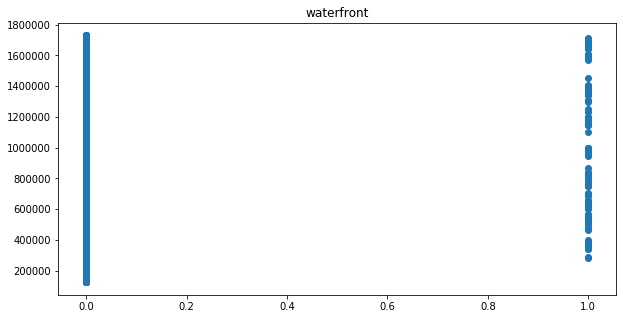

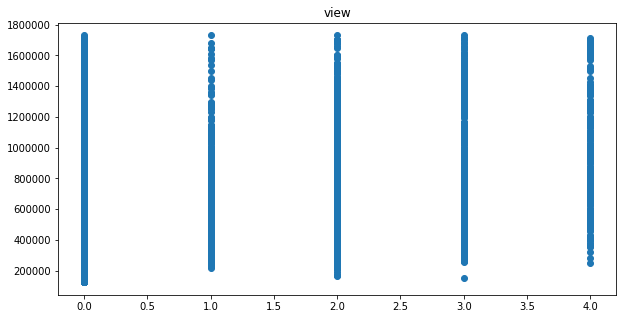

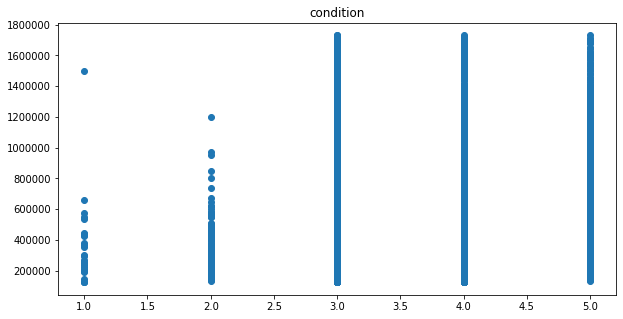

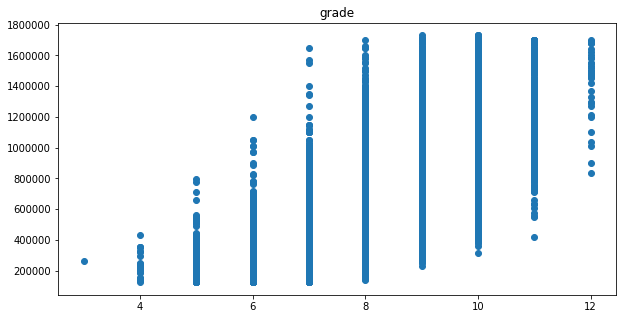

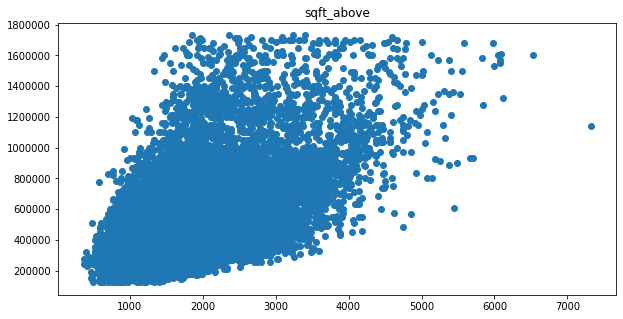

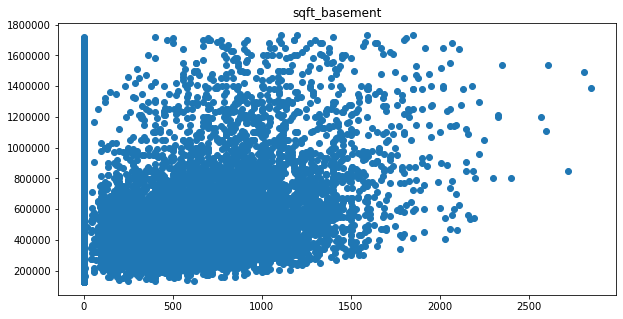

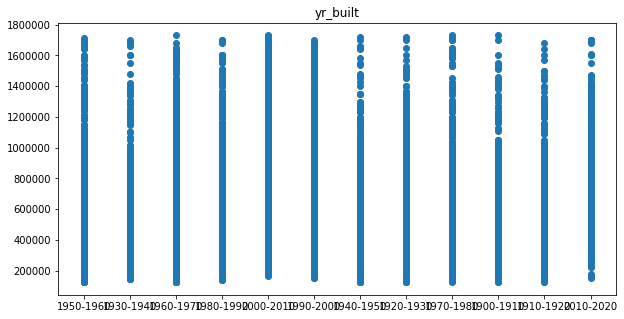

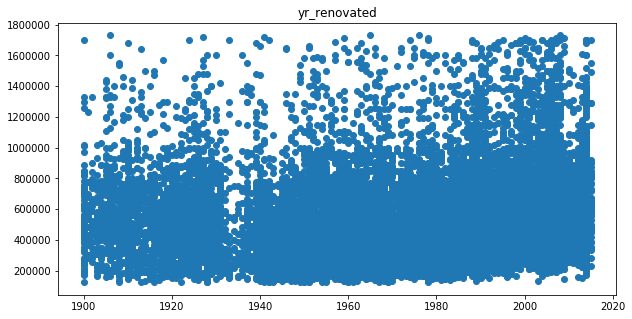

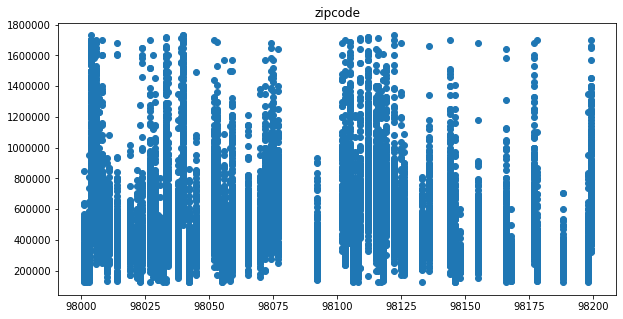

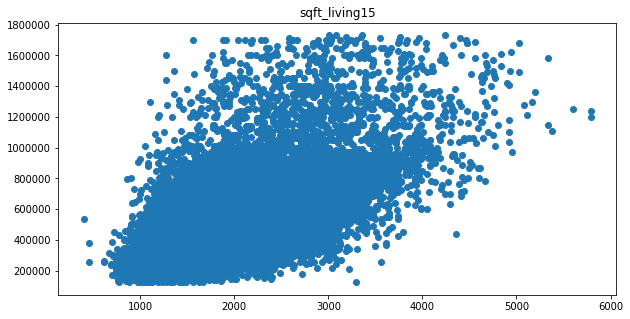

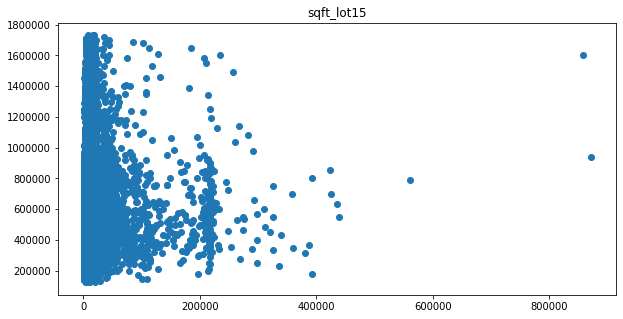

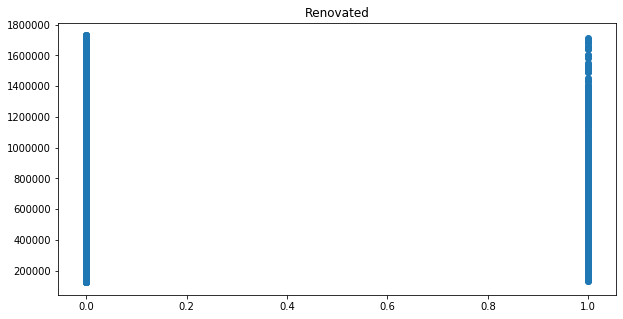

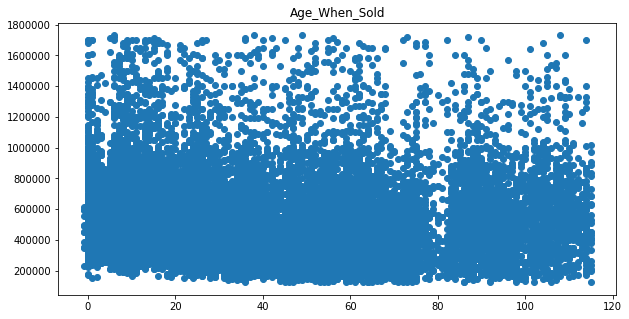

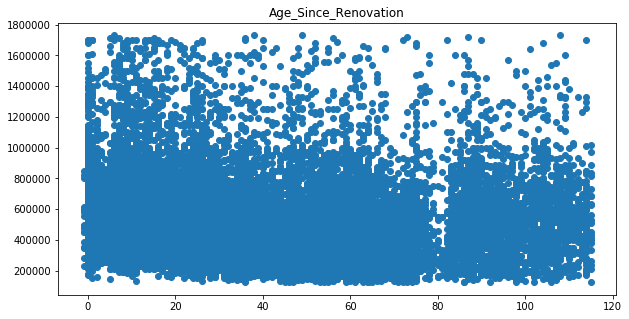

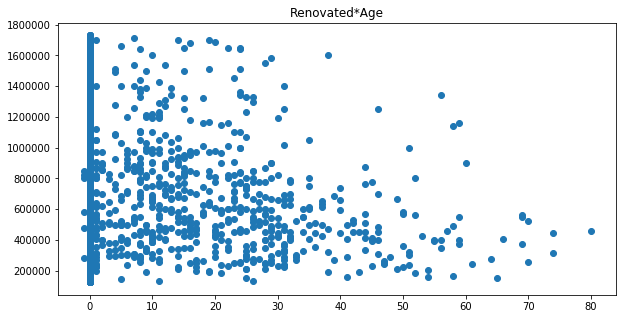

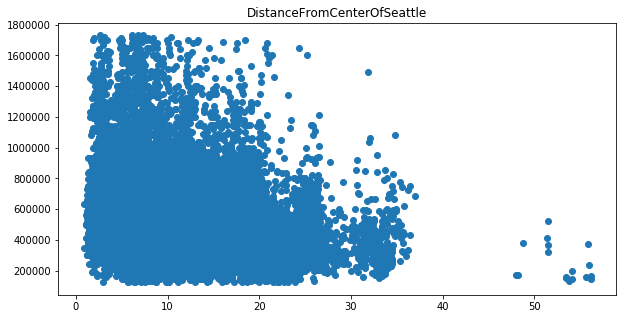

In [9]:
col = list(df.columns)
col.remove('price')
for column in col:
    plt.figure(figsize=(10,5))
    plt.scatter(x=df[column],y=df['price'])
    plt.title(column)
    plt.show()

In [10]:
df.groupby('floors').price.mean()

floors
1.0    434340.500332
1.5    543319.299417
2.0    600064.141948
2.5    784703.394161
3.0    558983.574751
3.5    511916.666667
Name: price, dtype: float64

In [11]:
df.groupby('bedrooms').price.mean()

bedrooms
1     331053.967568
2     404435.375415
3     456816.638880
4     597044.943172
5     678507.925877
6     673851.580392
7     658906.781250
8     694600.000000
9     893999.833333
10    820000.000000
11    520000.000000
Name: price, dtype: float64

In [12]:
df[df['bedrooms']>9]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold,Age_Since_Renovation,Renovated*Age,DistanceFromCenterOfSeattle
8748,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1910-1920,1999.0,98106,1420,4960,1,96,15.0,15.0,3.724195
13301,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2000-2010,2008.0,98004,2730,10400,0,6,6.0,0.0,12.158580
15147,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1950-1960,1958.0,98006,2040,11914,0,56,56.0,0.0,9.022925
19239,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1910-1920,1913.0,98105,1810,3745,0,101,101.0,0.0,4.112360


In [13]:
df.groupby('yr_built').price.mean()

yr_built
1900-1910    590486.476038
1910-1920    550961.313776
1920-1930    567119.279966
1930-1940    542317.136634
1940-1950    436813.529686
1950-1960    464458.543722
1960-1970    442818.585301
1970-1980    482108.517897
1980-1990    506697.418109
1990-2000    548268.407205
2000-2010    565220.889245
2010-2020    590593.296603
Name: price, dtype: float64

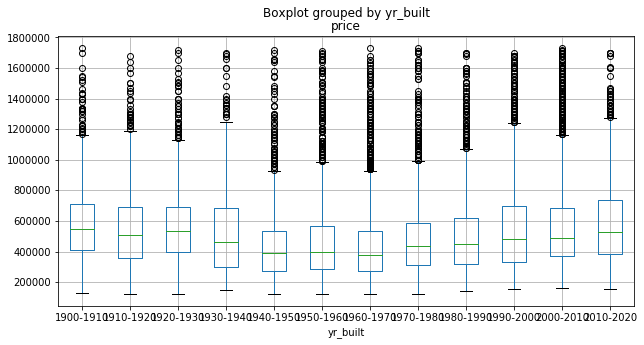

In [14]:
df.boxplot(column='price',by='yr_built',figsize=(10,5));

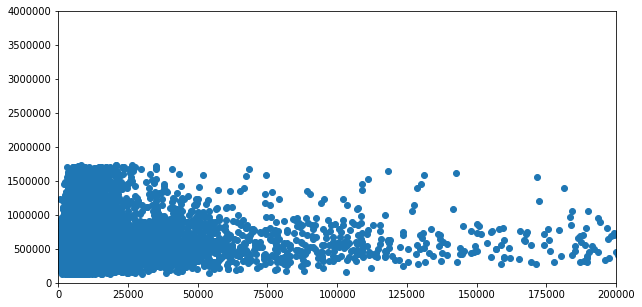

In [15]:
plt.figure(figsize=(10,5))
plt.xlim((-.05,200000))
plt.ylim((-.05,4000000))
plt.scatter(x=df['sqft_lot'],y=df['price'])
plt.show()

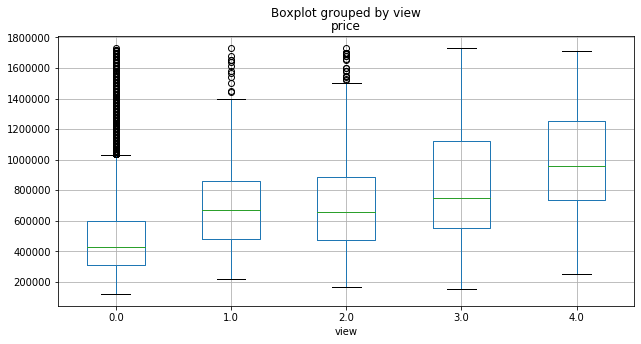

In [16]:
df.boxplot(column='price',by='view',figsize=(10,5));

In [17]:
df.groupby('view').price.mean()

view
0.0    485979.942913
1.0    714300.574194
2.0    717012.633588
3.0    836975.826087
4.0    998578.722944
Name: price, dtype: float64

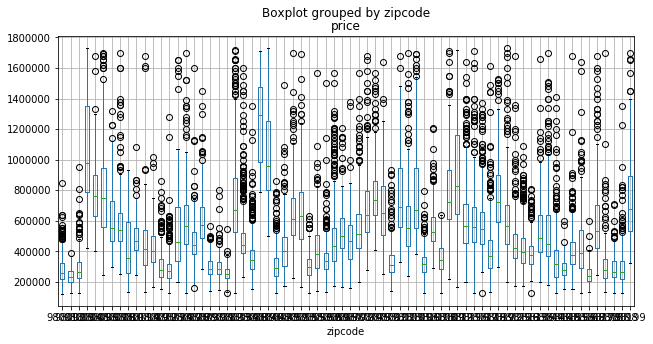

In [18]:
df.boxplot(column='price',by='zipcode',figsize=(10,5));

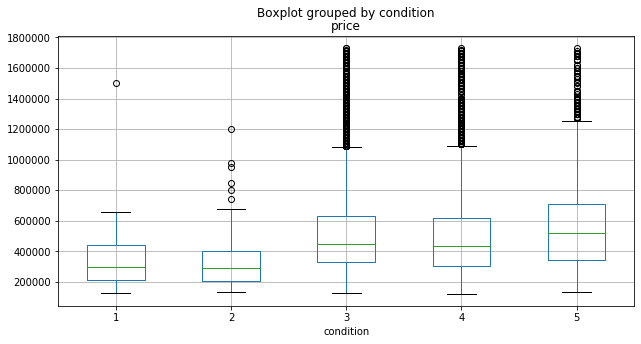

In [19]:
df.boxplot(column='price',by='condition',figsize=(10,5));

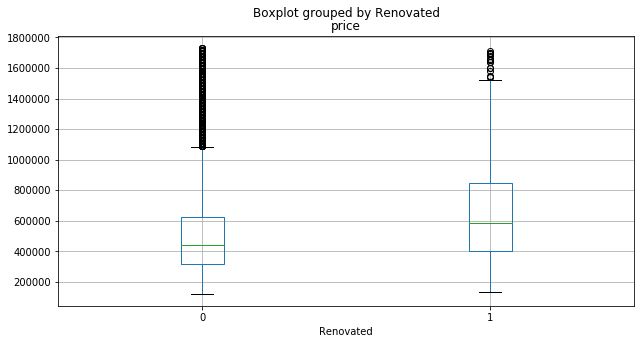

In [20]:
df.boxplot(column='price',by='Renovated',figsize=(10,5));

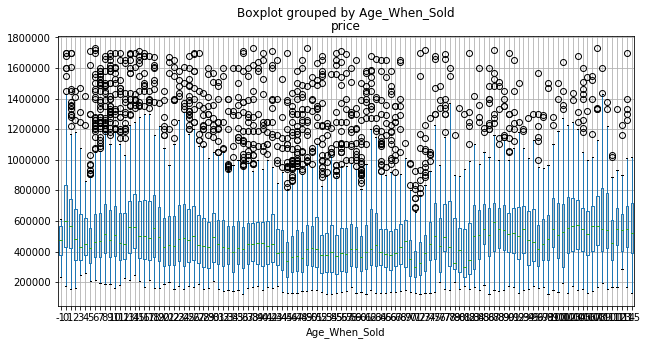

In [21]:
df.boxplot(column='price',by='Age_When_Sold',figsize=(10,5));

Looking at linearity. It looks like the features that could have strong linear relationships are:
1. bathrooms
2. sqft_living
3. sqft_above
4. sqft_living15
5. grade

Ones that seem like they could have a mild linear relationship are:

1. bedrooms
2. grade
3. sqft_basement
4. condition
5. Floors

The variable grade seems like it's actually exponential, might be worth exploring later.

In [22]:
# These are the variables that are going to be dropped
# for not meeting the linearity assumption, some categoricals are going to stay
# for example zipcode

non_linearity = ['sqft_lot','yr_built','yr_renovated','sqft_lot15',
                 'Age_When_Sold','Age_Since_Renovation','Renovated*Age','zipcode',
                'floors']

df = df.drop(non_linearity,axis=1)

In [23]:
#Creating Dummie Variables double check this list
#Taking out bedrooms, bathrooms, view, condition
dummy_list = ['Renovated','waterfront'] #Trying grade as a continuous variable, Also try without zipcode
dum=df[dummy_list].astype('category')
dummies = pd.get_dummies(dum[dummy_list],prefix=dummy_list,drop_first=True)
df_preprocessed = df.drop(dummy_list, axis=1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis=1)

## Notes

In [24]:
df_preprocessed.head()

,price,bedrooms,bathrooms,sqft_living,view,condition,grade,sqft_above,sqft_basement,sqft_living15,DistanceFromCenterOfSeattle,Renovated_1,waterfront_1.0
0,221900.0,3,1.00,1180,0.0,3,7,1180,0.0,1340,7.729734,0,0
1,538000.0,3,2.25,2570,0.0,3,7,2170,400.0,1690,8.048045,1,0
2,180000.0,2,1.00,770,0.0,3,6,770,0.0,2720,10.711811,0,0
3,604000.0,4,3.00,1960,0.0,5,7,1050,910.0,1360,6.632568,0,0
4,510000.0,3,2.00,1680,0.0,3,8,1680,0.0,1800,15.822203,0,0


# Modeling

## First Model

In [25]:
#Omitting zones for now, too much data to process
y = df_preprocessed['price']
X = df_preprocessed.drop(['price'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

{'Lagrange multiplier statistic': 1277.4274698982429, 'p-value': 3.638372595534746e-266, 'f-value': 115.04116550653185, 'f p-value': 5.899844758761294e-277}
Train Mean Squarred Error: 21990520625.97995
Test Mean Squarred Error: 22559163035.085533
Train Mean Error: 148292.01133567496
Test Mean Error: 150197.08064767948
Difference in Mean Error: 1905.069312004518


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     3155.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:45:24   Log-Likelihood:            -2.2586e+05
No. Observations:               16949   AIC:                         4.517e+05
Df Residuals:                   16936   BIC:                         4.518e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.714e+05   1.33e+04    -27.961      0.000   -3.97e+05   -3.45e+05
bedrooms                    -1.507e+04   1659.361     -9.085      0.000   -1.83e+04   -1.18e+04
bathrooms                     705.4451   2393.345      0.295      0.768   -3985.761    5396.651
sqft_living                    72.7161     15.855      4.586      0.000      41.638     103.794
view                         3.836e+04   1768.988     21.683      0.000    3.49e+04    4.18e+04
condition                    4.466e+04   1847.219     24.178      0.000     4.1e+04    4.83e+04
grade                        7.179e+04   1758.082     40.833      0.000    6.83e+04    7.52e+04
sqft_above                     53.2308     15.822      3.364      0.001      22.219      84.243
sqft_basement                  22.8263     15.776      1.447      0.148      -8.096      53.748
sqft_living15                  71.9805      2.892     24.893      0.000      66.313      77.648
DistanceFromCenterOfSeattle -1.357e+04    171.635    -79.071      0.000   -1.39e+04   -1.32e+04
Renovated_1                   9.11e+04   6314.875     14.426      0.000    7.87e+04    1.03e+05
waterfront_1.0               2.497e+05   1.82e+04     13.707      0.000    2.14e+05    2.85e+05
==============================================================================
Omnibus:                     2950.250   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8513.665
Skew:                           0.922   Prob(JB):                         0.00
Kurtosis:                       5.941   Cond. No.                     5.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

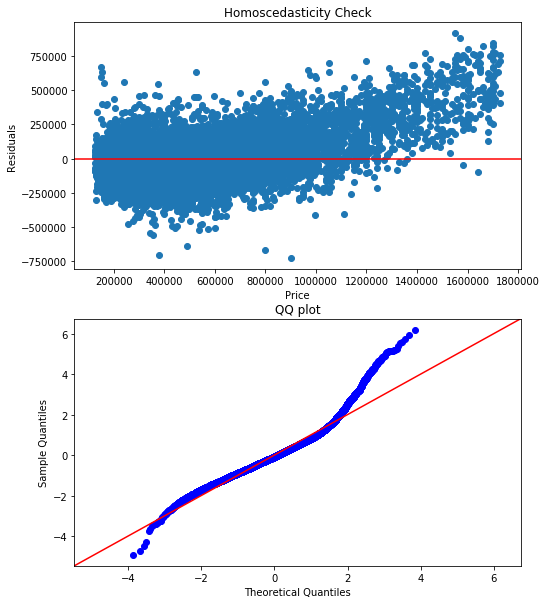

In [26]:
ModelCheck(X_train, y_train, X_test, y_test)

## Looking at Multicollinearity

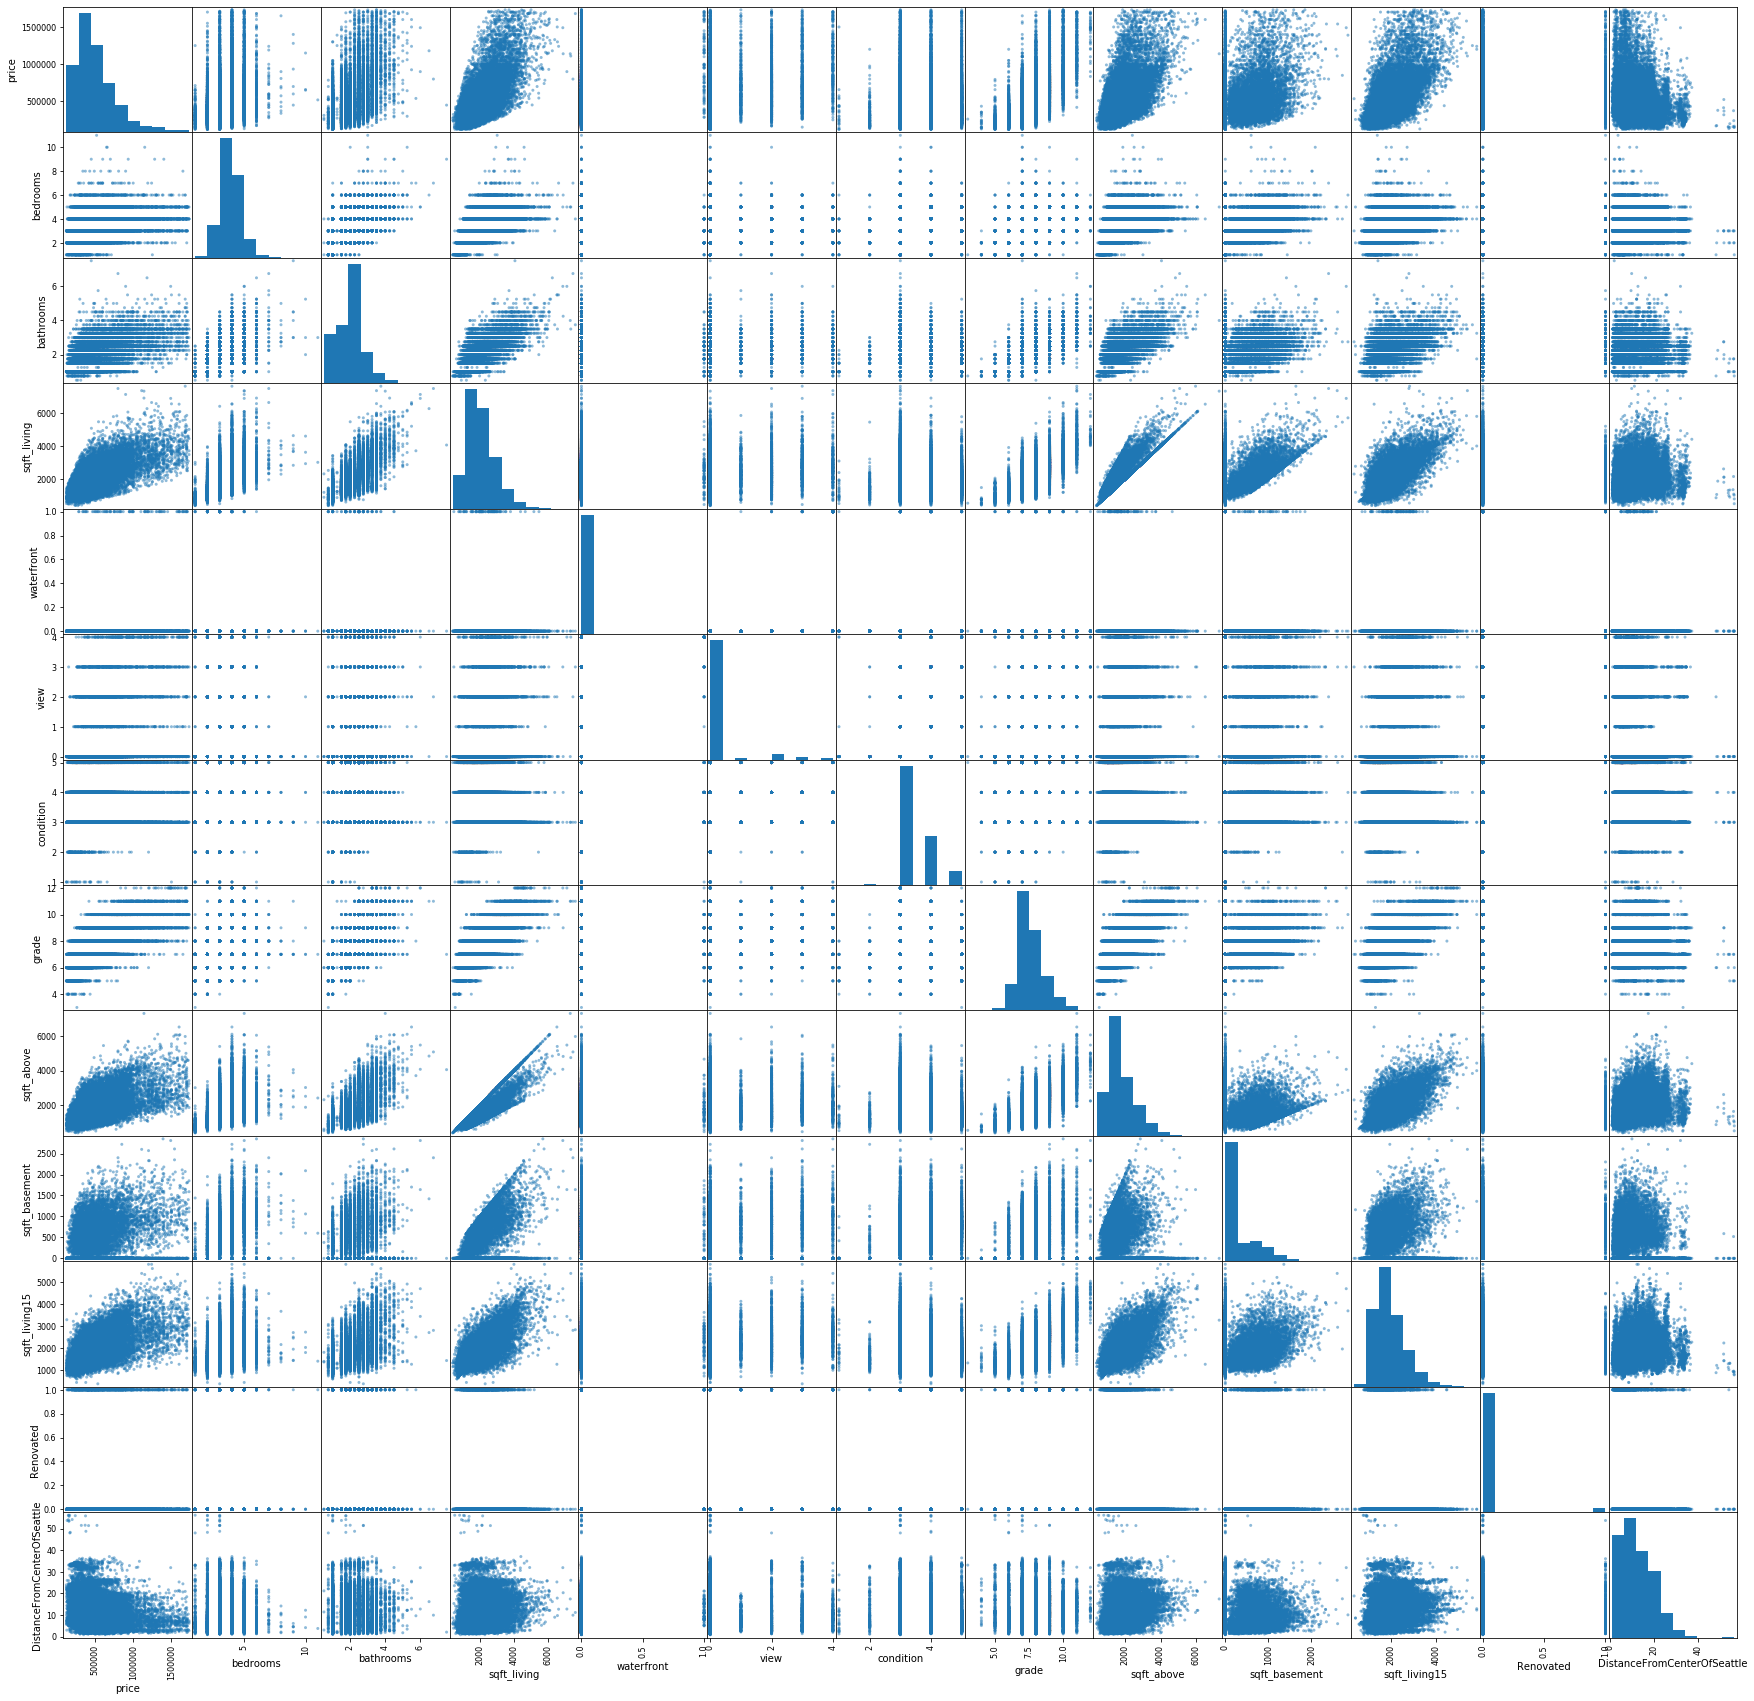

In [27]:
pd.plotting.scatter_matrix(df,figsize  = [30, 30]);
plt.show()

In [28]:
test_corr=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr['pairs'] = list(zip(test_corr.level_0, test_corr.level_1))
test_corr.set_index(['pairs'],inplace=True)
test_corr.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr.columns = ['cc']
test_corr.drop_duplicates(inplace=True)
test_corr[(test_corr.cc >.75) & (test_corr.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.863839
"(sqft_living, sqft_living15)",0.752585


It looks like sqft_living is highly correlated with a bunch of variables. Let's take out sqft_living to see if this will fix the correlation.

In [29]:
df = df.drop(['sqft_living'],axis=1)

In [30]:
test_corr2=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr2['pairs'] = list(zip(test_corr2.level_0, test_corr2.level_1))
test_corr2.set_index(['pairs'],inplace=True)
test_corr2.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr2.columns = ['cc']
test_corr2.drop_duplicates(inplace=True)
test_corr2[(test_corr2.cc >.75) & (test_corr2.cc<1)]

,cc
pairs,


Sqft_above and grade also seems to be correlated but I believe they are very different and just happen to be correlated so I'm going to keep those variables.

In [31]:
#dropping sqft_living from actual test/train set
X_train = X_train.drop(['sqft_living'],axis=1)
X_test = X_test.drop(['sqft_living'],axis=1)

## Second Model after removing collinearity

{'Lagrange multiplier statistic': 1270.268185483103, 'p-value': 1.153158443215526e-265, 'f-value': 124.74647771289689, 'f p-value': 2.3995302657313253e-276}
Train Mean Squarred Error: 22017831441.018417
Test Mean Squarred Error: 22589548014.256737
Train Mean Error: 148384.06734221306
Test Mean Error: 150298.19697606732
Difference in Mean Error: 1914.1296338542597


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3436.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:46:19   Log-Likelihood:            -2.2587e+05
No. Observations:               16949   AIC:                         4.518e+05
Df Residuals:                   16937   BIC:                         4.519e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.756e+05   1.33e+04    -28.334      0.000   -4.02e+05    -3.5e+05
bedrooms                     -1.45e+04   1655.675     -8.761      0.000   -1.78e+04   -1.13e+04
bathrooms                    1539.6549   2387.834      0.645      0.519   -3140.749    6220.058
view                         3.866e+04   1768.829     21.854      0.000    3.52e+04    4.21e+04
condition                    4.514e+04   1845.351     24.462      0.000    4.15e+04    4.88e+04
grade                        7.203e+04   1758.299     40.968      0.000    6.86e+04    7.55e+04
sqft_above                    124.3367      3.155     39.408      0.000     118.152     130.521
sqft_basement                  93.3245      3.549     26.294      0.000      86.368     100.281
sqft_living15                  72.5583      2.891     25.102      0.000      66.892      78.224
DistanceFromCenterOfSeattle -1.359e+04    171.670    -79.182      0.000   -1.39e+04   -1.33e+04
Renovated_1                  9.136e+04   6318.357     14.459      0.000     7.9e+04    1.04e+05
waterfront_1.0               2.495e+05   1.82e+04     13.689      0.000    2.14e+05    2.85e+05
==============================================================================
Omnibus:                     2946.727   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8447.112
Skew:                           0.924   Prob(JB):                         0.00
Kurtosis:                       5.924   Cond. No.                     4.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

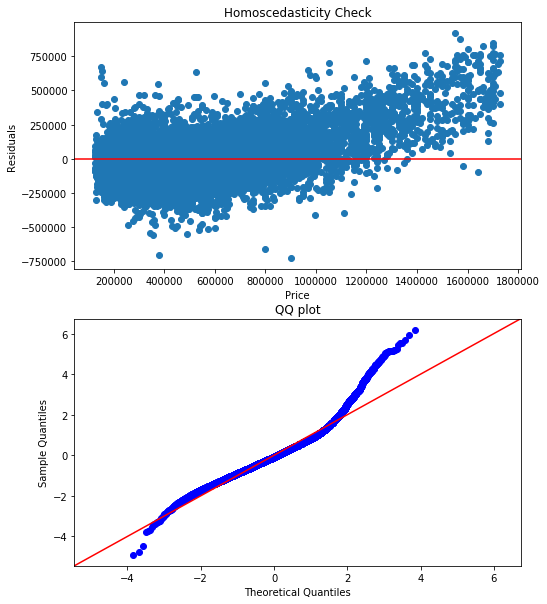

In [32]:
ModelCheck(X_train, y_train, X_test, y_test)

## Stepwise Selection of features

In [33]:
len(X_train.columns)

11

In [34]:
results = stepwise_selection(X_train,y_train)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  grade                          with p-value 0.0
Add  DistanceFromCenterOfSeattle    with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  view                           with p-value 2.9534e-234
Add  sqft_living15                  with p-value 3.70834e-125
Add  condition                      with p-value 2.93528e-113
Add  Renovated_1                    with p-value 3.83314e-52
Add  waterfront_1.0                 with p-value 2.18324e-43
Add  bedrooms                       with p-value 1.43043e-18


In [35]:
len(results)

10

## Third Model using Selected Features

In [36]:
X_train=X_train[results]
X_test=X_test[results]

{'Lagrange multiplier statistic': 1269.4403764785766, 'p-value': 1.5044713709007484e-266, 'f-value': 137.13255737449805, 'f p-value': 3.1138455920056173e-277}
Train Mean Squarred Error: 22018371917.08375
Test Mean Squarred Error: 22592927607.126106
Train Mean Error: 148385.88853756865
Test Mean Error: 150309.43951437683
Difference in Mean Error: 1923.550976808183


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3779.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:46:21   Log-Likelihood:            -2.2587e+05
No. Observations:               16949   AIC:                         4.518e+05
Df Residuals:                   16938   BIC:                         4.518e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.759e+05   1.33e+04    -28.368      0.000   -4.02e+05    -3.5e+05
grade                        7.231e+04   1706.713     42.366      0.000     6.9e+04    7.57e+04
DistanceFromCenterOfSeattle -1.359e+04    171.332    -79.298      0.000   -1.39e+04   -1.33e+04
sqft_above                    125.0027      2.981     41.930      0.000     119.159     130.846
sqft_basement                  93.9996      3.391     27.718      0.000      87.352     100.647
view                         3.864e+04   1768.676     21.849      0.000    3.52e+04    4.21e+04
sqft_living15                  72.3987      2.880     25.139      0.000      66.754      78.044
condition                    4.502e+04   1835.696     24.525      0.000    4.14e+04    4.86e+04
Renovated_1                  9.143e+04   6317.319     14.472      0.000     7.9e+04    1.04e+05
waterfront_1.0               2.496e+05   1.82e+04     13.696      0.000    2.14e+05    2.85e+05
bedrooms                     -1.43e+04   1623.541     -8.805      0.000   -1.75e+04   -1.11e+04
==============================================================================
Omnibus:                     2945.217   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8443.997
Skew:                           0.923   Prob(JB):                         0.00
Kurtosis:                       5.924   Cond. No.                     4.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

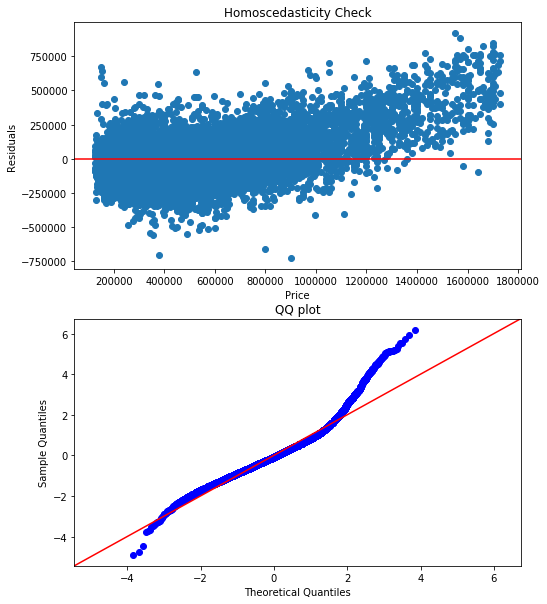

In [37]:
ModelCheck(X_train, y_train, X_test, y_test)

## Scaling features

In [38]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'Renovated',
       'DistanceFromCenterOfSeattle'],
      dtype='object')

In [41]:
continuous_features = ['bathrooms','sqft_above','sqft_basement',
                       'bedrooms','condition','sqft_living15',
                       'DistanceFromCenterOfSeattle']
len(continuous_features)

7

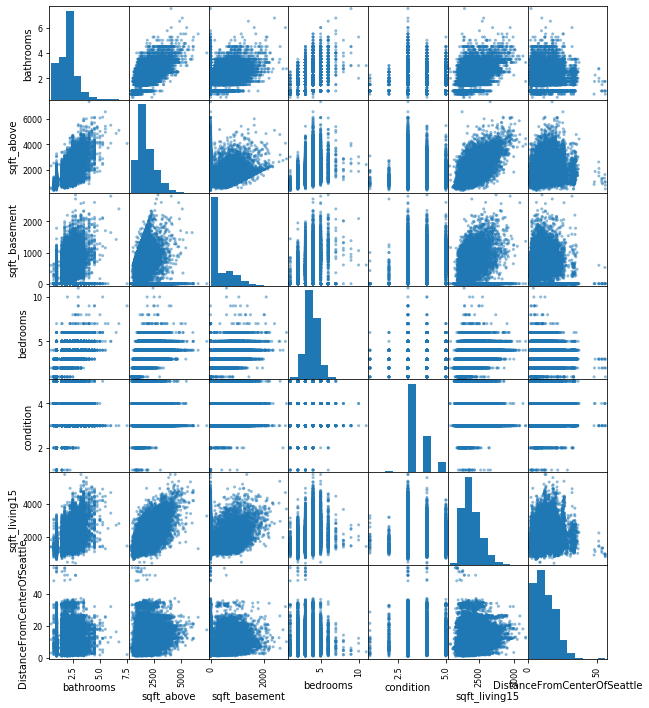

In [42]:
pd.plotting.scatter_matrix(df[continuous_features], figsize=(10,12));

In [43]:
Log_transform=['sqft_living15','sqft_above','DistanceFromCenterOfSeattle']
for feature in Log_transform:
    X_train[feature] = X_train[feature].map(lambda x: np.log(x))
    X_test[feature] = X_test[feature].map(lambda x: np.log(x))

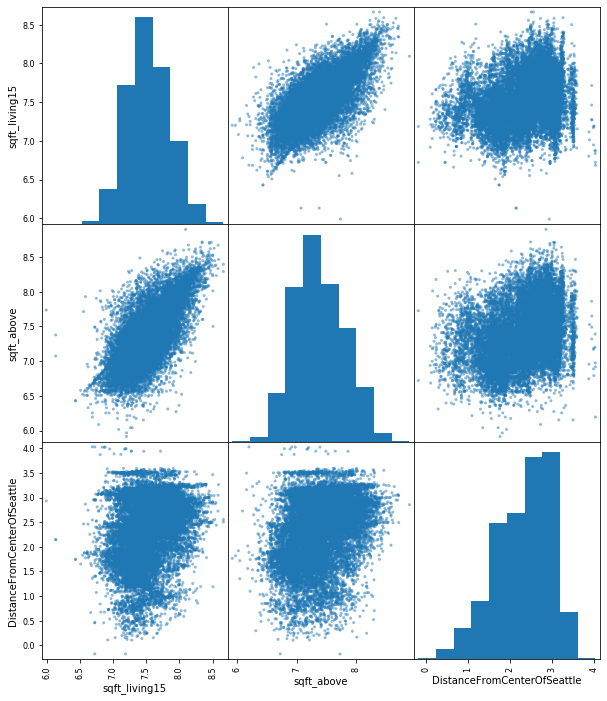

In [44]:
pd.plotting.scatter_matrix(X_train[Log_transform], figsize=(10,12));

## Fourth Model

{'Lagrange multiplier statistic': 1460.051517011109, 'p-value': 1.069955701575218e-307, 'f-value': 159.66450286986782, 'f p-value': 5.63e-322}
Train Mean Squarred Error: 22308871443.640907
Test Mean Squarred Error: 22862272165.558826
Train Mean Error: 149361.54606738948
Test Mean Error: 151202.75184519237
Difference in Mean Error: 1841.205777802883


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     3708.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:48:35   Log-Likelihood:            -2.2598e+05
No. Observations:               16949   AIC:                         4.520e+05
Df Residuals:                   16938   BIC:                         4.521e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        -2.66e+06   3.62e+04    -73.464      0.000   -2.73e+06   -2.59e+06
grade                        8.035e+04   1693.700     47.443      0.000     7.7e+04    8.37e+04
DistanceFromCenterOfSeattle -1.564e+05   1909.840    -81.882      0.000    -1.6e+05   -1.53e+05
sqft_above                   2.052e+05   5538.500     37.045      0.000    1.94e+05    2.16e+05
sqft_basement                  82.7027      3.390     24.394      0.000      76.057      89.348
view                         3.562e+04   1779.818     20.012      0.000    3.21e+04    3.91e+04
sqft_living15                1.665e+05   5713.639     29.148      0.000    1.55e+05    1.78e+05
condition                    4.644e+04   1846.575     25.149      0.000    4.28e+04    5.01e+04
Renovated_1                  8.123e+04   6369.246     12.753      0.000    6.87e+04    9.37e+04
waterfront_1.0                2.81e+05   1.84e+04     15.307      0.000    2.45e+05    3.17e+05
bedrooms                    -1.153e+04   1682.621     -6.854      0.000   -1.48e+04   -8235.133
==============================================================================
Omnibus:                     2743.669   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7763.402
Skew:                           0.868   Prob(JB):                         0.00
Kurtosis:                       5.825   Cond. No.                     1.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

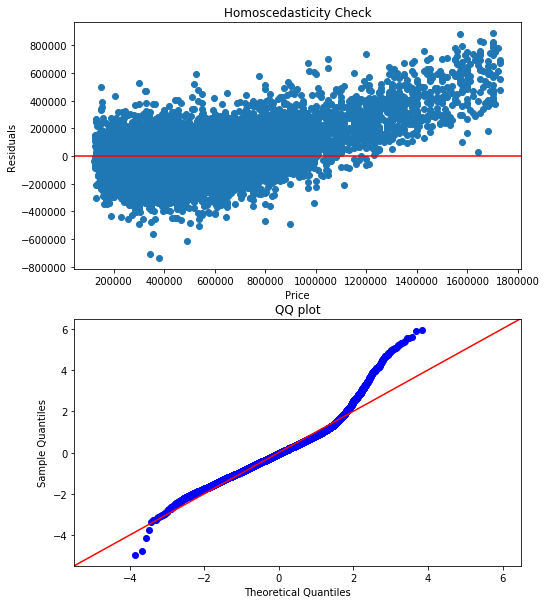

In [45]:
ModelCheck(X_train, y_train, X_test, y_test)

## Fifth Model

In [48]:
#dropping bedrooms
#seems weird that increasing in number has a negative correlation
X_train = X_train.drop(['bedrooms'],axis=1)
X_test = X_test.drop(['bedrooms'],axis=1)

{'Lagrange multiplier statistic': 1437.5904176601907, 'p-value': 5.831737089344686e-304, 'f-value': 174.4332056956082, 'f p-value': 8.299083e-318}
Train Mean Squarred Error: 22370750798.193
Test Mean Squarred Error: 22995747876.776886
Train Mean Error: 149568.54882692752
Test Mean Error: 151643.4893979194
Difference in Mean Error: 2074.9405709918647


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     4104.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:49:51   Log-Likelihood:            -2.2601e+05
No. Observations:               16949   AIC:                         4.520e+05
Df Residuals:                   16939   BIC:                         4.521e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        -2.58e+06   3.43e+04    -75.156      0.000   -2.65e+06   -2.51e+06
grade                        8.213e+04   1675.928     49.009      0.000    7.88e+04    8.54e+04
DistanceFromCenterOfSeattle -1.562e+05   1912.241    -81.682      0.000    -1.6e+05   -1.52e+05
sqft_above                    1.87e+05   4869.930     38.401      0.000    1.77e+05    1.97e+05
sqft_basement                  73.0135      3.086     23.661      0.000      66.965      79.062
view                         3.668e+04   1775.481     20.659      0.000    3.32e+04    4.02e+04
sqft_living15                1.674e+05   5720.159     29.257      0.000    1.56e+05    1.79e+05
condition                    4.583e+04   1846.932     24.814      0.000    4.22e+04    4.94e+04
Renovated_1                  8.204e+04   6376.791     12.865      0.000    6.95e+04    9.45e+04
waterfront_1.0               2.835e+05   1.84e+04     15.427      0.000    2.48e+05     3.2e+05
==============================================================================
Omnibus:                     2745.410   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7733.823
Skew:                           0.870   Prob(JB):                         0.00
Kurtosis:                       5.815   Cond. No.                     1.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

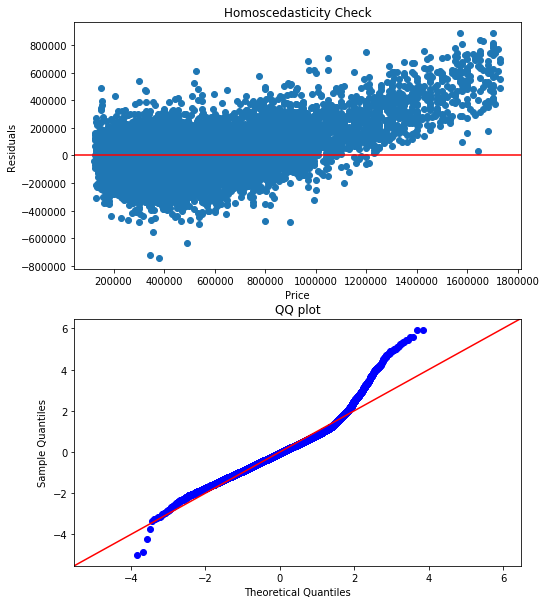

In [49]:
ModelCheck(X_train, y_train, X_test, y_test)

## Scratch Work

In [58]:
y_log_train = y_train.apply(lambda x: np.log(x))
y_log_test = y_test.apply(lambda x: np.log(x))

{'Lagrange multiplier statistic': 276.7919167743022, 'p-value': 2.161368487496078e-54, 'f-value': 31.246799429692743, 'f p-value': 7.475226431823334e-55}
Train Mean Squarred Error: 19893758844.697006
Test Mean Squarred Error: 20294070144.325207
Train Mean Error: 141045.23687348329
Test Mean Error: 142457.25725397497
Difference in Mean Error: 1412.0203804916819


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     4336.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:32:52   Log-Likelihood:                -1528.8
No. Observations:               16949   AIC:                             3078.
Df Residuals:                   16939   BIC:                             3155.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           6.9831      0.061    114.900      0.000       6.864       7.102
grade                           0.1298      0.003     43.742      0.000       0.124       0.136
DistanceFromCenterOfSeattle    -0.3147      0.003    -92.941      0.000      -0.321      -0.308
sqft_above                      0.3588      0.009     41.615      0.000       0.342       0.376
sqft_basement                   0.0001   5.46e-06     24.580      0.000       0.000       0.000
view                            0.0372      0.003     11.827      0.000       0.031       0.043
sqft_living15                   0.3755      0.010     37.074      0.000       0.356       0.395
condition                       0.0763      0.003     23.325      0.000       0.070       0.083
Renovated_1                     0.1219      0.011     10.799      0.000       0.100       0.144
waterfront_1.0                  0.3953      0.033     12.148      0.000       0.332       0.459
==============================================================================
Omnibus:                       51.814   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.255
Skew:                          -0.084   Prob(JB):                     1.36e-13
Kurtosis:                       3.236   Cond. No.                     1.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

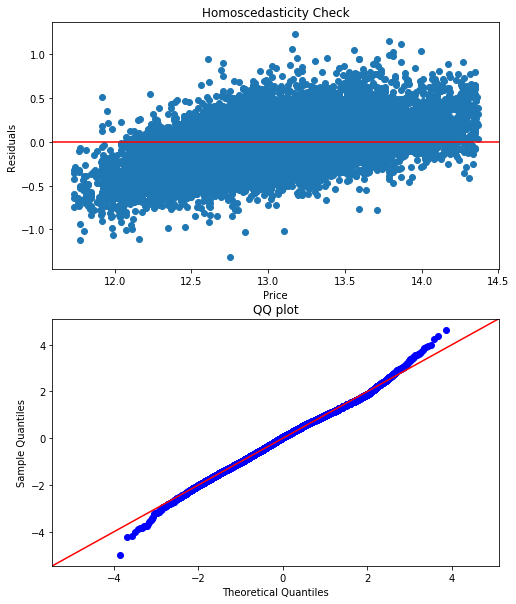

In [87]:
LoggedModelCheck(X_train,y_log_train,X_test,y_log_test)

# Thing I need to do

In [ ]:
# Look at non-linear relationships (polynomial...etc.)